In [0]:
!pip install openpyxl
!pip install geopy

     |████████████████████████████████| 249 kB 7.6 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-dadfa8db-f693-405d-a906-fb45f18b948f/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 125 kB 5.0 MB/s 
     |████████████████████████████████| 40 kB 2.7 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-dadfa8db-f693-405d-a906-fb45f18b948f/bin/python -m pip install --upgrade pip' command.


In [0]:
import pandas as pd
import numpy as np


In [0]:
url = 'https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dataset/Liverpool.xlsx'
shipdf = pd.read_excel(url)
shipdf.head(5)

,Name,IMO,Flag,LLI Vessel Type,Company contact,Gross Tonnes,DWT,Prior Place,Arrived at,Sailed at
0,Stena Foreteller,9214666,Denmark (Int. Register),roll on roll off with container capacity,Stena Line Service AB,24688,11644,Belfast,01/09/2023 22:45:04 GMT,02/09/2023 03:07:21 GMT
1,Royal Iris of the Mersey,8633712,U.K.,ferry,Mersey Ferries Limited,464,—,Birkenhead,01/09/2023 21:33:55 GMT,02/09/2023 08:36:41 GMT
2,Seatruck Power,9506215,Isle of Man,Roll On Roll Off,Seatruck Ferries Holding Limited,19722,5600,Dublin,01/09/2023 19:57:09 GMT,02/09/2023 00:54:45 GMT
3,Manannan,9176072,Isle of Man,passenger ro/ro,Isle of Man Steam Packet Company Limited,5743,800,Douglas,01/09/2023 17:51:25 GMT,01/09/2023 19:12:38 GMT
4,Stena Embla,9807322,Cyprus,passenger ro/ro,Bocom Leasing Management Hong Kong Company Lim...,42000,9748,Belfast,01/09/2023 17:19:36 GMT,01/09/2023 21:30:43 GMT



### Data Cleaning 

In [0]:
shipdf.replace("—", np.nan, inplace=True)
shipdf.head(5)

,Name,IMO,Flag,LLI Vessel Type,Company contact,Gross Tonnes,DWT,Prior Place,Arrived at,Sailed at
0,Stena Foreteller,9214666.0,Denmark (Int. Register),roll on roll off with container capacity,Stena Line Service AB,24688.0,11644.0,Belfast,01/09/2023 22:45:04 GMT,02/09/2023 03:07:21 GMT
1,Royal Iris of the Mersey,8633712.0,U.K.,ferry,Mersey Ferries Limited,464.0,NaN,Birkenhead,01/09/2023 21:33:55 GMT,02/09/2023 08:36:41 GMT
2,Seatruck Power,9506215.0,Isle of Man,Roll On Roll Off,Seatruck Ferries Holding Limited,19722.0,5600.0,Dublin,01/09/2023 19:57:09 GMT,02/09/2023 00:54:45 GMT
3,Manannan,9176072.0,Isle of Man,passenger ro/ro,Isle of Man Steam Packet Company Limited,5743.0,800.0,Douglas,01/09/2023 17:51:25 GMT,01/09/2023 19:12:38 GMT
4,Stena Embla,9807322.0,Cyprus,passenger ro/ro,Bocom Leasing Management Hong Kong Company Lim...,42000.0,9748.0,Belfast,01/09/2023 17:19:36 GMT,01/09/2023 21:30:43 GMT
5,Fugro Seeker,NaN,U.K.,support,Unknown Owners,NaN,NaN,Liverpool,01/09/2023 17:14:28 GMT,02/09/2023 07:27:26 GMT
6,Njord Skua,8355592.0,U.K.,tender,Njord Offshore Limited,66.0,18.0,Birkenhead,01/09/2023 17:07:53 GMT,02/09/2023 07:55:03 GMT
7,Spectrum 3,9609603.0,U.K.,supply,Unknown Owners,49.0,NaN,Birkenhead,01/09/2023 16:43:19 GMT,02/09/2023 08:29:11 GMT
8,KITTIWAKE,NaN,U.K.,pilot ship,AIS Unknown,NaN,NaN,Liverpool,01/09/2023 15:52:41 GMT,02/09/2023 00:06:42 GMT
9,Lara 1,8521672.0,Panama,crane barge,Hapo International Barges B.V.,1793.0,2346.0,Birkenhead,01/09/2023 15:46:43 GMT,13/09/2023 07:45:20 GMT


In [0]:
shipdf['Arrived at'] = pd.to_datetime(shipdf['Arrived at'].str.replace(' GMT', ''), format='%d/%m/%Y %H:%M:%S')
shipdf['Sailed at'] = pd.to_datetime(shipdf['Sailed at'].str.replace(' GMT', ''), format='%d/%m/%Y %H:%M:%S')


In [0]:
import pandas as pd
from pyspark.sql import SparkSession

# Replace spaces with underscores in column names
shipdf.columns = [c.replace(' ', '_') for c in shipdf.columns]

# Create a Spark DataFrame from the Pandas DataFrame
ship_spark_df = spark.createDataFrame(shipdf)


#### Feature Extraction , calculating Docking Time

In [0]:
from pyspark.sql.functions import unix_timestamp, col

ship_spark_df = ship_spark_df.withColumn(
    "Docking_Time_Hours",
    (unix_timestamp("Sailed_at") - unix_timestamp("Arrived_at")) / 3600
)


In [0]:
# Save the DataFrame as a permanent table
ship_spark_df.write.mode("overwrite").saveAsTable("ShipSparkTable")


### 01. What is average docking time of the ship?

In [0]:
%sql
SELECT 
        CAST(AVG(Docking_Time_Hours) AS INT) as Hours, 
        
        CAST((AVG(Docking_Time_Hours) - CAST(AVG(Docking_Time_Hours) AS INT)) * 60 AS INT) as Minutes
FROM 
    ShipSparkTable


Hours,Minutes
46,26



### 02. How the gross Tonnes can be co-related with docking time e.g., for ships we don’t have Gross Tonnes or DWT?

#### Analysis Method
1. To explore the relationship between a ship's Gross Tonnes and its docking time, I conducted a scatter plot analysis. The data was limited to docking times of up to 1000 hours to focus on the most relevant range and exclude extreme outliers.



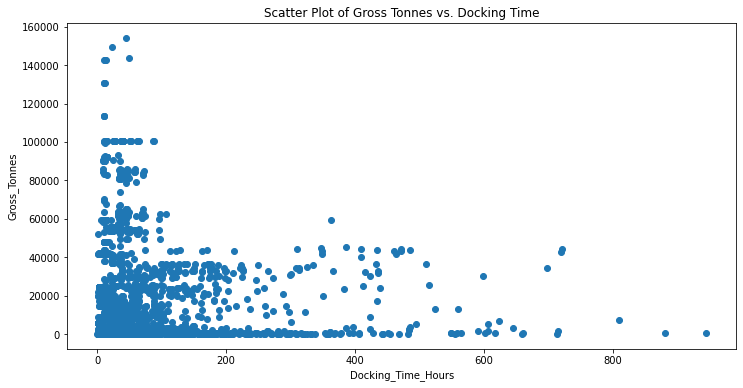

In [0]:
import matplotlib.pyplot as plt
ship_pandas_df = ship_spark_df.toPandas()

filtered_shipdf = ship_pandas_df[ship_pandas_df['Docking_Time_Hours'] <= 1000].copy()
filtered_shipdf.dropna(inplace=True)

# Scatter plot of Gross Tonnes vs. Docking Time (Hours)
plt.figure(figsize=(12, 6))  # Width: 12 inches, Height: 6 inches

plt.scatter( filtered_shipdf['Docking_Time_Hours'],filtered_shipdf['Gross_Tonnes'])

plt.xlabel('Docking_Time_Hours')
plt.ylabel('Gross_Tonnes')
plt.title('Scatter Plot of Gross Tonnes vs. Docking Time')
plt.show()


##### Outcome of Analysis
- The scatter plot analysis between Docking Time (Hours) and Gross Tonnes reveals no direct linear relationship between these two variables.
- Instances are noted where ships with higher Gross Tonnes values have relatively short docking times, particularly less than 200 hours. This indicates that larger ships don't necessarily spend a longer time docked.
- Focusing on "Lara 1" as a specific example:
  - Despite its Gross Tonnes and DWT values remaining constant across different port visits, the docking time for each visit varies.
  - There's no apparent pattern linking the dates of "Lara 1's" visits to the Liverpool port with the duration of its stay.
- These observations suggest that the size of a ship, as indicated by its Gross Tonnes and DWT, does not have a straightforward or consistent impact on its docking time.
- Other factors, perhaps related to port operations, external conditions, might be more influential in determining how long a ship stays docked.


*Further Analysis*:
To illustrate the variation in docking time for a ship with consistent Gross Tonnes and DWT, I have queried the data for "Lara 1".

In [0]:
%sql
-- Diffrent docking time for same gross tonnes and DWT
select Docking_Time_Hours,Name,Flag,LLI_Vessel_Type,Gross_Tonnes,DWT,Prior_Place from ShipSparkTable where Name='Lara 1' limit 5

Docking_Time_Hours,Name,Flag,LLI_Vessel_Type,Gross_Tonnes,DWT,Prior_Place
1446.4472222222223,Lara 1,Panama,crane barge,1793.0,2346.0,Ellesmere Port
92.37555555555555,Lara 1,Panama,crane barge,1793.0,2346.0,Ellesmere Port
212.66305555555556,Lara 1,Panama,crane barge,1793.0,2346.0,Ellesmere Port
103.63305555555556,Lara 1,Panama,crane barge,1793.0,2346.0,Ellesmere Port
1364.7183333333332,Lara 1,Panama,crane barge,1793.0,2346.0,Birkenhead


#### Data Imputation for Gross Tonnes
To fill missing Gross Tonnes data, it's a good idea to use the LLI Vessel Type. This works well because ships of the same type usually have similar sizes and weights. So, this method provides a realistic way to fill in missing information, making sure it matches the actual size and weight of the ships.

In [0]:
%sql
merge into ShipSparkTable as Target
using (
  select LLI_Vessel_Type,avg(Gross_Tonnes) as avg_gross_tonnes from ShipSparkTable where Gross_Tonnes is not null
group by all
) as source
on Target.LLI_Vessel_Type=source.LLI_Vessel_Type and Target.Gross_Tonnes is null
when matched then
update set  Target.Gross_Tonnes=source.avg_gross_tonnes


num_affected_rows,num_updated_rows,num_deleted_rows,num_inserted_rows
598,598,0,0


#### Data Imputation for DWT
To estimate missing DWT (Deadweight Tonnage) data, it's practical to consider each ship's type. Generally, ships of the same type, when loaded to their full capacity, tend to carry similar weights. So, using the ship type to update missing DWT values is likely to provide a good estimate, reflecting what each ship type can typically carry when fully loaded. This approach helps ensure that the data for each ship's carrying capacity is realistic and consistent with others of the same type.

In [0]:
%sql
merge into ShipSparkTable as Target
using (
  select LLI_Vessel_Type,avg(DWT) as avg_DWT from ShipSparkTable where DWT is not null
group by all
) as source
on Target.LLI_Vessel_Type=source.LLI_Vessel_Type and Target.DWT is null
when matched then
update set  Target.DWT=source.avg_DWT


num_affected_rows,num_updated_rows,num_deleted_rows,num_inserted_rows
1174,1174,0,0


Records where Gross_Tonnes is still missing
  - Given that there are four different ships classified as pilot ships, each with distinct names, it would be more accurate to verify their weights individually and obtain this information from reliable sources. Pilot ships, being specialized vessels, can vary in size and weight, even among ships of the same classification. 
  - Manual update needs to be made as data is not available for similar Vessel Type

In [0]:
%sql
-- Records where Gross_Tonnes is still missing
select  name,LLI_Vessel_Type,count(*) from ShipSparkTable where Gross_Tonnes is null
group by all

name,LLI_Vessel_Type,count(1)
TURNSTONE,pilot ship,1
RAZORBILL,pilot ship,472
PETREL,pilot ship,430
KITTIWAKE,pilot ship,486


Records where DWT is still missing
- For the mentioned categories like pusher tugs, pilot ships, unspecified vessel types, naval vessels, fishery protection boats, drill platforms, and trawlers, it's important to recognize that these are often smaller or support vessels. They are typically used to assist or accompany larger ships and have unique operational roles. Because of their specialized functions and variations in design and capacity, a customized approach should be taken for each individual vessel type when estimating missing DWT data. 
- Manual update needs to be made as data is not available for similar Vessel Type

In [0]:
%sql
-- Records where DWT is missing
select  LLI_Vessel_Type,count(*) from ShipSparkTable where DWT is null
group by all

LLI_Vessel_Type,count(1)
pusher tug,27
pilot ship,1389
Vessel Type (unspecified),179
Naval Vessel,4
fishery protection,2
drill platform,1
trawler (All types),2



### 03. How the Vessel Type (column D) can be co-related with docking time and Gross Tonnes or DWT?



##### 1. Analyzing the docking times of different vessel types, particularly focusing on a single month, allows for more effective berth planning and allocation based on the trends and patterns observed in the data.

In [0]:
%sql
SELECT 
    LLI_Vessel_Type,
        CAST(AVG(Docking_Time_Hours) AS INT) as Hours, 
                CAST((AVG(Docking_Time_Hours) - CAST(AVG(Docking_Time_Hours) AS INT)) * 60 AS INT) as Minutes
FROM 
    ShipSparkTable
     where cast(Arrived_at as date) BETWEEN '2023-01-01' and '2023-01-30'
group by LLI_Vessel_Type order by 2 desc

LLI_Vessel_Type,Hours,Minutes
support,2027,26
yacht,645,44
crane barge,298,38
bulk carrier,170,22
Vessel Type (unspecified),166,31
supply,108,2
tug,79,37
dredger,70,27
general cargo with container capacity,61,39
Combined chemical and oil tanker,60,6


##### 2. Knowing the frequency of each vessel type, combined with their size range (Gross Tonnes), aids in better resource allocation

In [0]:
%sql
SELECT 
    LLI_Vessel_Type,
    MIN(Gross_Tonnes) AS Min_Gross_Tonnes,
    MAX(Gross_Tonnes) AS Max_Gross_Tonnes,
    ROUND(AVG(Gross_Tonnes), 2) AS Avg_Gross_Tonnes,
    count(LLI_Vessel_Type) as count_vessel
FROM ShipSparkTable
GROUP BY LLI_Vessel_Type
ORDER BY Avg_Gross_Tonnes DESC;


LLI_Vessel_Type,Min_Gross_Tonnes,Max_Gross_Tonnes,Avg_Gross_Tonnes,count_vessel
crude oil tanker,56500.0,154381.0,71130.17,89
passenger (cruise),693.0,149215.0,67655.17,94
bulk carrier,3092.0,45843.0,30056.64,203
roll on roll off with container capacity,7606.0,100430.0,29447.3,608
passenger ro/ro,2382.0,63621.0,27557.72,1326
Naval Vessel,7280.0,65000.0,26520.0,4
product tanker,2159.0,64933.0,23816.4,57
Naval Auxiliary Vessel,22000.0,22000.0,22000.0,1
fully cellular containership,3838.0,73819.0,19401.75,487
Roll On Roll Off,5499.0,19722.0,18074.79,935


### 04. How can we cluster the last port prior to arrival (Column H) with column F, G and I, J?


Expected Output
1. By analyzing the minimum and maximum Gross Tonnes and DWT, we get a clear picture of the range of vessel sizes coming from each prior port. This indicates the capacity and types of ships the prior ports can handle.
2. The count of ships from each prior port helps understand the volume of traffic. More ships from a particular port can indicate a stronger commercial or trading relationship.
3. Ports handling larger vessels (with higher Gross Tonnes and DWT) are likely to be larger and better equipped. This data helps estimate the infrastructure and capacity of these prior ports.
4. Knowing the range and frequency of vessels from each port can aid in strategic decision-making for resource allocation, logistical planning, and enhancing operational efficiency at the Liverpool Port.
5. Identifying the most frequented prior ports can help in analyzing key trade routes, understanding market dynamics, and planning for future trade engagements.

In [0]:
%sql
select Prior_place,min(Gross_Tonnes) as min_Gross_Tonnes,max(Gross_Tonnes) as max_Gross_Tonnes,min(DWT) as min_DWT,max(DWT) as max_DWT,count(Prior_Place) as Count_of_Ships from ShipSparkTable
group by all
order by 6 desc

Prior_place,min_Gross_Tonnes,max_Gross_Tonnes,min_DWT,max_DWT,Count_of_Ships
Liverpool,20.0,59652.0,5.0,81987.0,3425
Birkenhead,25.0,62826.0,5.0,114139.0,2451
Dublin,38.98830409356725,43062.0,8.123076923076923,81758.0,1605
Belfast,38.98830409356725,142714.0,8.123076923076923,82362.0,1031
Eastham,26.192307692307693,12164.0,8.123076923076923,17653.0,357
Douglas,8.0,15651.0,8.123076923076923,4168.0,268
Rotterdam,221.0,62775.0,187.0,112905.0,126
Bilbao,3953.0,43672.0,6886.0,82597.0,111
Antwerpen,2262.0,100430.0,3450.0,67601.0,93
Holyhead,20.0,92822.0,8.123076923076923,11936.0,83


1. The results show which times of day are most common for ships arriving from or departing to each prior port. This information could be useful for understanding and managing port traffic, scheduling, and operational planning.
2. Similar data analyses can also be conducted based on the day of the week or the day of the month. This approach helps identify which specific days tend to be the busiest at the port. Such insights are valuable for effective planning and resource allocation, ensuring the port's operations are optimized for peak times.


In [0]:
%sql
SELECT 
  Prior_Place,
  SUM(CASE WHEN HOUR(`Arrived_at`) >= 6 AND HOUR(`Arrived_at`) < 12 THEN 1 ELSE 0 END) AS Morning_Arrival_Count,
  SUM(CASE WHEN HOUR(`Arrived_at`) >= 12 AND HOUR(`Arrived_at`) < 18 THEN 1 ELSE 0 END) AS Afternoon_Arrival_Count,
  SUM(CASE WHEN HOUR(`Arrived_at`) >= 18 OR HOUR(`Arrived_at`) < 6 THEN 1 ELSE 0 END) AS Evening_Arrival_Count,
  SUM(CASE WHEN HOUR(`Arrived_at`) < 6 THEN 1 ELSE 0 END) AS Night_Arrival_Count,
  SUM(CASE WHEN HOUR(`Sailed_at`) >= 6 AND HOUR(`Sailed_at`) < 12 THEN 1 ELSE 0 END) AS Morning_Departure_Count,
  SUM(CASE WHEN HOUR(`Sailed_at`) >= 12 AND HOUR(`Sailed_at`) < 18 THEN 1 ELSE 0 END) AS Afternoon_Departure_Count,
  SUM(CASE WHEN HOUR(`Sailed_at`) >= 18 OR HOUR(`Sailed_at`) < 6 THEN 1 ELSE 0 END) AS Evening_Departure_Count,
  SUM(CASE WHEN HOUR(`Sailed_at`) < 6 THEN 1 ELSE 0 END) AS Night_Departure_Count
FROM ShipSparkTable
GROUP BY Prior_Place
order by 2 desc

Prior_Place,Morning_Arrival_Count,Afternoon_Arrival_Count,Evening_Arrival_Count,Night_Arrival_Count,Morning_Departure_Count,Afternoon_Departure_Count,Evening_Departure_Count,Night_Departure_Count
Liverpool,840,1142,1443,704,1295,702,1428,679
Birkenhead,490,875,1086,453,1155,410,886,511
Belfast,203,217,611,243,347,52,632,233
Dublin,155,496,954,632,484,101,1020,321
Eastham,137,112,108,69,140,102,115,44
Douglas,92,149,27,10,80,12,176,11
Rotterdam,43,32,51,22,36,39,51,20
Bilbao,35,22,54,23,25,36,50,23
Holyhead,32,15,36,20,23,30,30,8
Runcorn,32,6,1,0,13,26,0,0


In [0]:
%sql
SELECT 
  Prior_Place,
  SUM(CASE WHEN DAYOFWEEK(`Arrived_at`) = 2 THEN 1 ELSE 0 END) AS Monday_Arrival_Count,
  SUM(CASE WHEN DAYOFWEEK(`Arrived_at`) = 3 THEN 1 ELSE 0 END) AS Tuesday_Arrival_Count,
  SUM(CASE WHEN DAYOFWEEK(`Arrived_at`) = 4 THEN 1 ELSE 0 END) AS Wednesday_Arrival_Count,
  SUM(CASE WHEN DAYOFWEEK(`Arrived_at`) = 5 THEN 1 ELSE 0 END) AS Thursday_Arrival_Count,
  SUM(CASE WHEN DAYOFWEEK(`Arrived_at`) = 6 THEN 1 ELSE 0 END) AS Friday_Arrival_Count,
  SUM(CASE WHEN DAYOFWEEK(`Arrived_at`) = 7 THEN 1 ELSE 0 END) AS Saturday_Arrival_Count,
  SUM(CASE WHEN DAYOFWEEK(`Arrived_at`) = 1 THEN 1 ELSE 0 END) AS Sunday_Arrival_Count,
  SUM(CASE WHEN DAYOFWEEK(`Sailed_at`) = 2 THEN 1 ELSE 0 END) AS Monday_Departure_Count,
  SUM(CASE WHEN DAYOFWEEK(`Sailed_at`) = 3 THEN 1 ELSE 0 END) AS Tuesday_Departure_Count,
  SUM(CASE WHEN DAYOFWEEK(`Sailed_at`) = 4 THEN 1 ELSE 0 END) AS Wednesday_Departure_Count,
  SUM(CASE WHEN DAYOFWEEK(`Sailed_at`) = 5 THEN 1 ELSE 0 END) AS Thursday_Departure_Count,
  SUM(CASE WHEN DAYOFWEEK(`Sailed_at`) = 6 THEN 1 ELSE 0 END) AS Friday_Departure_Count,
  SUM(CASE WHEN DAYOFWEEK(`Sailed_at`) = 7 THEN 1 ELSE 0 END) AS Saturday_Departure_Count,
  SUM(CASE WHEN DAYOFWEEK(`Sailed_at`) = 1 THEN 1 ELSE 0 END) AS Sunday_Departure_Count
FROM ShipSparkTable
GROUP BY Prior_Place
ORDER BY Monday_Arrival_Count DESC


Prior_Place,Monday_Arrival_Count,Tuesday_Arrival_Count,Wednesday_Arrival_Count,Thursday_Arrival_Count,Friday_Arrival_Count,Saturday_Arrival_Count,Sunday_Arrival_Count,Monday_Departure_Count,Tuesday_Departure_Count,Wednesday_Departure_Count,Thursday_Departure_Count,Friday_Departure_Count,Saturday_Departure_Count,Sunday_Departure_Count
Liverpool,458,478,519,492,484,481,513,463,488,506,502,473,482,511
Birkenhead,313,330,402,383,342,340,341,298,341,389,384,337,348,354
Dublin,142,268,263,281,265,267,119,129,269,270,271,282,249,135
Belfast,137,166,164,170,170,113,111,82,174,170,168,168,158,111
Eastham,54,51,49,67,51,44,41,62,59,43,71,48,39,35
Douglas,44,30,25,45,46,44,34,44,29,26,45,46,44,34
Bilbao,23,18,18,14,17,11,10,15,19,22,16,15,13,11
Antwerpen,19,11,10,10,13,14,16,16,19,9,12,15,12,10
Rotterdam,13,19,18,23,16,21,16,17,12,19,19,17,21,21
Dunkerque,11,6,1,2,1,3,8,7,14,2,2,2,2,3



### 05. How can we cluster the Flag (Column C) to the last port prior to arrival (Column H), column D,  column F, G and I.J?


##### 1. Considering Flags represent country , we can determine how much ships  are comming to Liverpool Street  and depending upon weight of ship we can determine size

In [0]:
%sql
select Flag,min(Gross_Tonnes) as min_Gross_Tonnes,max(Gross_Tonnes) as max_Gross_Tonnes,min(DWT) as min_DWT,max(DWT) as max_DWT,count(Prior_Place) as Count_of_Ships from ShipSparkTable
where Flag!='U.K.'
group by all
order by 6 desc

Flag,min_Gross_Tonnes,max_Gross_Tonnes,min_DWT,max_DWT,Count_of_Ships
Isle of Man,277.0,43672.0,260.0,82561.0,1185
Cyprus,2446.0,42000.0,697.0,77997.0,1008
Netherlands,38.98830409356725,99902.0,8.123076923076923,23317.0,683
Denmark (Int. Register),118.0,25189.0,18.0,39522.0,595
Bermuda,17464.0,149215.0,6722.0,54155.0,288
Malta,306.0,130818.0,223.0,164565.0,271
Madeira,2461.0,60148.0,3691.0,112038.0,181
Antigua & Barbuda,1262.0,11864.0,1008.0,17110.0,142
Panama,1793.0,86071.0,1437.0,85802.0,140
Liberia,851.0,85431.0,1280.0,164608.0,137


#### 2. Considering Flags represent country , we can determine how much ships  are comming to Liverpool Street  and at which time of the day 

In [0]:
%sql
SELECT 
  Flag,
  SUM(CASE WHEN HOUR(`Arrived_at`) >= 6 AND HOUR(`Arrived_at`) < 12 THEN 1 ELSE 0 END) AS Morning_Arrival_Count,
  SUM(CASE WHEN HOUR(`Arrived_at`) >= 12 AND HOUR(`Arrived_at`) < 18 THEN 1 ELSE 0 END) AS Afternoon_Arrival_Count,
  SUM(CASE WHEN HOUR(`Arrived_at`) >= 18 OR HOUR(`Arrived_at`) < 6 THEN 1 ELSE 0 END) AS Evening_Arrival_Count,
  SUM(CASE WHEN HOUR(`Arrived_at`) < 6 THEN 1 ELSE 0 END) AS Night_Arrival_Count,
  SUM(CASE WHEN HOUR(`Sailed_at`) >= 6 AND HOUR(`Sailed_at`) < 12 THEN 1 ELSE 0 END) AS Morning_Departure_Count,
  SUM(CASE WHEN HOUR(`Sailed_at`) >= 12 AND HOUR(`Sailed_at`) < 18 THEN 1 ELSE 0 END) AS Afternoon_Departure_Count,
  SUM(CASE WHEN HOUR(`Sailed_at`) >= 18 OR HOUR(`Sailed_at`) < 6 THEN 1 ELSE 0 END) AS Evening_Departure_Count,
  SUM(CASE WHEN HOUR(`Sailed_at`) < 6 THEN 1 ELSE 0 END) AS Night_Departure_Count
FROM ShipSparkTable
GROUP BY Flag
order by 2 desc

Flag,Morning_Arrival_Count,Afternoon_Arrival_Count,Evening_Arrival_Count,Night_Arrival_Count,Morning_Departure_Count,Afternoon_Departure_Count,Evening_Departure_Count,Night_Departure_Count
U.K.,1377,1906,2265,1015,2353,1143,2052,971
Isle of Man,262,450,473,309,340,120,725,192
Cyprus,197,254,557,280,388,50,570,137
Netherlands,147,172,364,268,249,129,305,70
Malta,89,72,110,51,93,59,119,42
Madeira,57,49,75,32,58,50,73,29
Antigua & Barbuda,50,31,61,29,26,34,82,30
Denmark (Int. Register),46,103,446,122,144,31,420,403
Panama,43,38,59,25,49,39,52,22
Marshall Islands,41,35,60,27,36,30,70,29


####3. Understanding the average docking times for ships from different countries can assist in efficient planning and resource allocation at the port. 

In [0]:
%sql
SELECT Flag,
        CAST(AVG(Docking_Time_Hours) AS INT) as Hours, 
        
        CAST((AVG(Docking_Time_Hours) - CAST(AVG(Docking_Time_Hours) AS INT)) * 60 AS INT) as Minutes
FROM 
    ShipSparkTable
group by Flag
order by 2 desc

Flag,Hours,Minutes
Togo,2019,53
Republic of Ireland,416,33
Croatia,288,12
"Hong Kong, S.A.R., China",249,45
South Korea,223,28
Cayman Islands,211,55
Panama,157,21
Switzerland,150,29
Egypt,148,31
Thailand,141,8


### More Strategic Analysis :

1. **Efficiency Analysis Based on Time of Day**:
   - Evaluate the port's ability to handle ships at different times of the day. This assessment should compare the port's capabilities at these times to maximize efficiency and throughput.
   - Consider the potential for redistributing ship arrivals and departures to less busy times, if feasible, to balance the workload and reduce congestion.

2. **Comparative Analysis with Nearby Ports**:
   - Examine the types of vessels, traffic, and capacities at Liverpool Port in contrast to neighboring ports. This analysis can uncover opportunities for collaborative load sharing or specialization based on each port's strengths and capacities.
   - Such a comparative study will help in identifying areas where Liverpool Port can complement or leverage nearby port facilities to optimize traffic.



### Data Integration
  - By adding diffrent source like travel time or distance
####Travel Time or Distance Travel vs. Docking Time Analysis:
  - Compare the time traveled by ships from their prior port to the docking time at Liverpool.
  - Longer travel times might be associated with specific regions or vessel types

In [0]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Photon

def find_port_coordinates(port_name):
    """Find the coordinates of a port using geocoding."""
    #geolocator = Nominatim(user_agent="geoapiExercises")
    geolocator = Photon(user_agent="measurements")

    try:
        location = geolocator.geocode(port_name)
        if location:
            return (location.latitude, location.longitude)
        else:
            return None
    except GeocoderTimedOut:
        return None

def calculate_distance_between_ports(port1, port2):
    """Calculate the distance between two ports."""
    coords_port1 = find_port_coordinates(port1)
    coords_port2 = find_port_coordinates(port2)

    if coords_port1 and coords_port2:
        distance = geodesic(coords_port1, coords_port2).kilometers
        return distance
    else:
        return "Could not find the location of one or both ports."




In [0]:

distance = calculate_distance_between_ports("Liverpool", "Birkenhead")
print(f"Distance: {distance} km")

Distance: 2.953989195498422 km
